## Imports


In [1]:
from numpy import pi

import qutip as qt

from rich import print as pprint

import matplotlib
from matplotlib import colors, cm, patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from oqd_compiler_infrastructure import PrettyPrint, Post

from trical.light_matter import *
from trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

muted_palette = sns.color_palette("muted", n_colors=10, desat=0.8)

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
)
upstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 10,
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
)
estate2 = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=1,
    energy=2 * np.pi * 110,
)

transitions = [
    Transition(
        level1=downstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=downstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate,
        einsteinA=1,
        multipole="E1",
    ),
    Transition(
        level1=upstate,
        level2=estate2,
        einsteinA=1,
        multipole="E1",
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, upstate, estate, estate2],
    transitions=transitions,
)

COM_x = Phonon(energy=0.1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 1,
    detuning=0,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[1],
    rabi=2 * np.pi * 1,
    detuning=0,
    phase=0,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

protocol = SequentialProtocol(
    sequence=[
        Pulse(beam=beam, duration=5),
        Pulse(beam=beam2, duration=5),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("6_example_sequential.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("6_example_sequential.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
backend = QutipBackend()

fock_cutoff = 10
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

printer = Post(PrettyPrint())

pprint(printer(experiment))

QutipExperiment
  - base: function(<function QutipCodeGeneration.map_OperatorAdd.<locals>.<lambda> at 0x0000021F379C09D0>)
  - sequence: list
    - 0: QutipGate
      - hamiltonian: function(<function QutipCodeGeneration.map_OperatorAdd.<locals>.<lambda> at 
0x0000021F38FD8A60>)
      - duration: float(5.0)
    - 1: QutipGate
      - hamiltonian: function(<function QutipCodeGeneration.map_OperatorAdd.<locals>.<lambda> at 
0x0000021F38FDC940>)
      - duration: float(5.0)

In [7]:
%timeit experiment.base(0)
%timeit experiment.sequence[0].hamiltonian(0)
%timeit experiment.sequence[1].hamiltonian(0)

301 μs ± 1.14 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


589 μs ± 899 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


592 μs ± 9.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Results


In [8]:
%%time
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

CPU times: total: 40.9 s
Wall time: 40.9 s


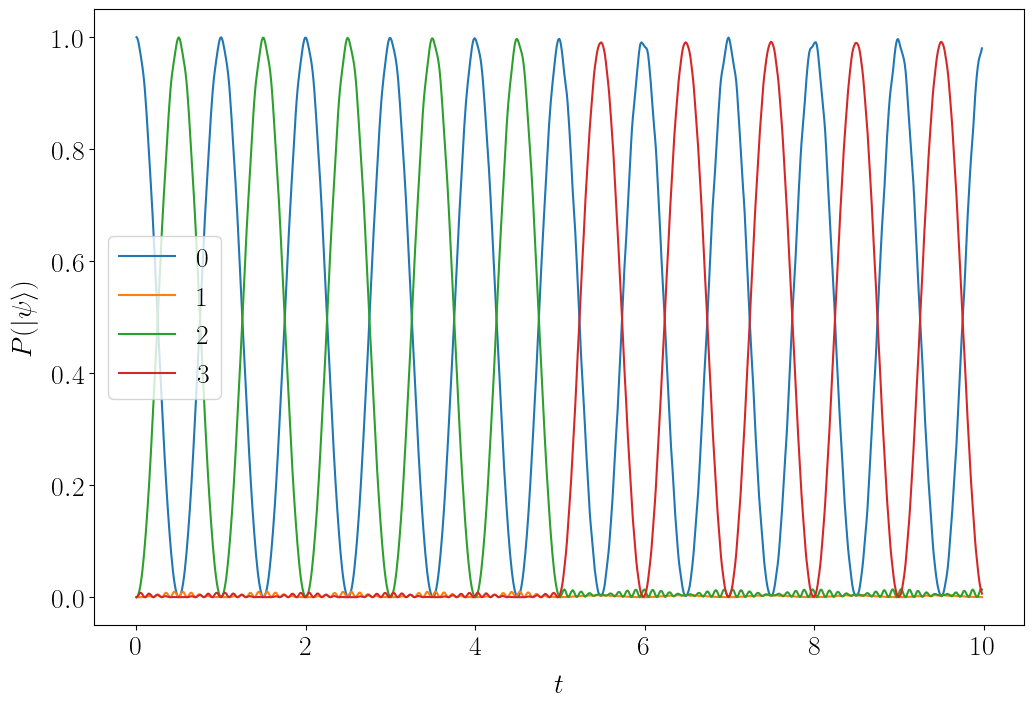

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:4] for s in result["states"][k]],
    label=range(4),
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()